# Bank Marketing Deposit Prediction using SVM

This project aims to predict whether a customer will subscribe to a term deposit 
based on demographic and campaign-related features.

The dataset is highly imbalanced, making accuracy an unreliable metric. 
Therefore, the main focus is on F1-score optimization for the positive class.


## Dataset

- Source: UCI Bank Marketing Dataset
- Samples: 45,211
- Features: 17
- Target: `y` (0 = No, 1 = Yes)

### Key Challenges
- Strong class imbalance (~12% positive class)
- Mixed categorical and numerical features


In [2]:
import pandas as pd

df = pd.read_csv("data/bank-full.csv", sep=";")
df.shape

(45211, 17)

## Target Variable Distribution

Before modeling, we inspect the class balance to understand the level of imbalance.

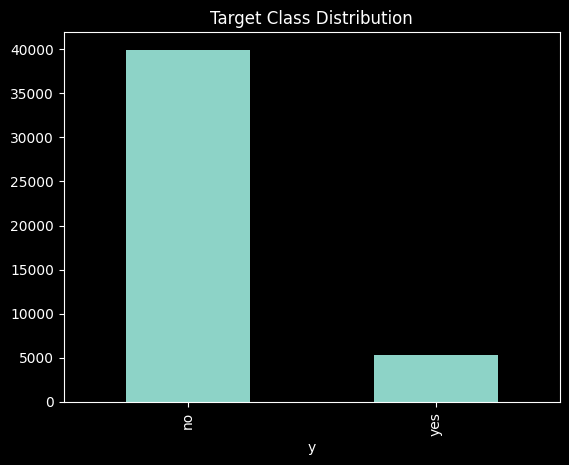

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

In [3]:
import matplotlib.pyplot as plt

df["y"].value_counts().plot(kind="bar", title="Target Class Distribution")
plt.show()

df["y"].value_counts(normalize=True)

### Insight

Only ~11–12% of customers subscribed

Accuracy would be misleading

F1-score and Recall are more meaningful metrics

## Binary Feature Encoding

Binary categorical features are mapped to numerical values.

In [4]:
binary_cols = ["default", "housing", "loan", "y"]
for col in binary_cols:
    df[col] = df[col].map({"yes": 1, "no": 0})

## One-Hot Encoding

Nominal categorical features are transformed using one-hot encoding.


In [5]:
categorical = ["job", "marital", "education", "contact", "month", "poutcome"]

X = df.drop("y", axis=1)
y = df["y"]

X = pd.get_dummies(X, columns=categorical, drop_first=True)
X.shape


(45211, 42)

## Train-Test Split

Stratified split is used to preserve class distribution.


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## Modeling Pipeline

Pipeline ensures:
- No data leakage
- Clean preprocessing
- Reproducible workflow


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report

base_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf"))
])

base_pipe.fit(X_train, y_train)
print(classification_report(y_test, base_pipe.predict(X_test)))


              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.68      0.32      0.43      1058

    accuracy                           0.90      9043
   macro avg       0.80      0.65      0.69      9043
weighted avg       0.89      0.90      0.89      9043



## Class Weight Optimization

To handle class imbalance, different weights are assigned to the positive class.


In [8]:
import numpy as np
from sklearn.metrics import precision_recall_curve

weights = [2, 3, 4, 5]
best_f1 = 0
best_weight = None

for w in weights:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", class_weight={0:1, 1:w}))
    ])
    
    pipe.fit(X_train, y_train)
    scores = pipe.decision_function(X_test)
    
    p, r, t = precision_recall_curve(y_test, scores)
    f1 = 2 * (p*r)/(p+r+1e-9)
    
    f1_max = np.max(f1)
    print(f"weight={w}  F1={f1_max:.3f}")
    
    if f1_max > best_f1:
        best_f1 = f1_max
        best_weight = w

print(best_weight, best_f1)


weight=2  F1=0.597
weight=3  F1=0.601
weight=4  F1=0.595
weight=5  F1=0.589
3 0.6006339139346182


## Threshold Optimization

Default threshold (0) is not optimal for imbalanced data.
Decision scores are used to find the threshold that maximizes F1-score.


In [9]:
final_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", class_weight={0:1, 1:3}))
])

final_pipe.fit(X_train, y_train)
scores = final_pipe.decision_function(X_test)

p, r, thresholds = precision_recall_curve(y_test, scores)
f1 = 2 * (p*r)/(p+r+1e-9)

best_idx = np.argmax(f1)
best_threshold = thresholds[best_idx]

best_threshold, f1[best_idx]


(np.float64(-0.0436563651264536), np.float64(0.6006339139346182))

## Final Model Evaluation


In [10]:
from sklearn.metrics import classification_report, f1_score

y_pred_final = (scores >= best_threshold).astype(int)

print(classification_report(y_test, y_pred_final))
print("Final F1:", f1_score(y_test, y_pred_final))


              precision    recall  f1-score   support

           0       0.96      0.91      0.94      7985
           1       0.52      0.72      0.60      1058

    accuracy                           0.89      9043
   macro avg       0.74      0.81      0.77      9043
weighted avg       0.91      0.89      0.90      9043

Final F1: 0.6006339144215531


## Final Results

- Model: SVM (RBF Kernel)
- Class Weight (positive): 3
- Optimized Threshold: ~ -0.04
- Final F1-score: ~0.60
- Recall (positive class): ~0.72

### Interpretation
The model successfully improves recall for the minority class while maintaining
reasonable precision a desirable trade-off in marketing prediction problems.
